In [14]:
import os
import re
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
def preprocess_code(code):
    code = re.sub(r'//.*|/\*[\s\S]*?\*/|#.*', '', code)  # Remove comments
    code = re.sub(r'\s+', ' ', code)  # Normalize whitespace
    return code.strip()

In [60]:
def load_code_files(folder_path):
    files = []
    contents = []
    code=[]
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".py") or filename.endswith(".cpp") or filename.endswith(".java"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                files.append(filename)
                contents.append(preprocess_code(file.read()))
                code.append(file.read())
    return files, contents,code

In [61]:
def compute_similarity_dag(code_folder, threshold=0.2):
    files, code_snippets,code = load_code_files(code_folder)
    
    # Vectorize using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(code_snippets)
    
    # Cosine similarity matrix
    similarity = cosine_similarity(tfidf_matrix)
    
    # 📊 Build DAG
    G = nx.DiGraph()
    G.add_nodes_from(files)

    cheaters = []  # Store suspicious file pairs with their code

    for i in range(len(files)):
        for j in range(i+1, len(files)):  # Only i -> j to prevent cycles
            sim_score = similarity[i][j]
            if sim_score > threshold:
                G.add_edge(files[i], files[j], weight=sim_score)
                cheaters.append((
                    files[i], files[j], sim_score,
                    code[i],  # preprocessed content of file i
                    code[j]   # preprocessed content of file j
                ))
    
    return G, similarity, files, cheaters


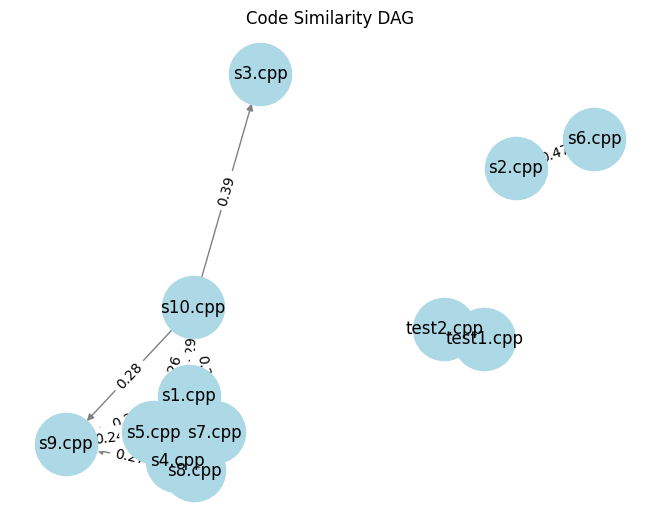

In [62]:
folder=r"kadance Algo"
dag, sim_matrix, filenames,cheaters = compute_similarity_dag(folder)

# 📈 Visualize
import matplotlib.pyplot as plt

pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000)
edge_labels = nx.get_edge_attributes(dag, 'weight')
nx.draw_networkx_edge_labels(dag, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})
plt.title("Code Similarity DAG")
plt.show()



In [63]:
for f1, f2, score, _, _ in cheaters:
    print(f" - {f1} and {f2} → Similarity: {score:.2f}")


 - s1.cpp and s10.cpp → Similarity: 0.29
 - s1.cpp and s5.cpp → Similarity: 0.32
 - s1.cpp and s7.cpp → Similarity: 0.28
 - s1.cpp and s8.cpp → Similarity: 0.28
 - s1.cpp and s9.cpp → Similarity: 0.28
 - s10.cpp and s3.cpp → Similarity: 0.39
 - s10.cpp and s5.cpp → Similarity: 0.26
 - s10.cpp and s7.cpp → Similarity: 0.28
 - s10.cpp and s8.cpp → Similarity: 0.29
 - s10.cpp and s9.cpp → Similarity: 0.28
 - s2.cpp and s6.cpp → Similarity: 0.47
 - s4.cpp and s7.cpp → Similarity: 0.34
 - s4.cpp and s8.cpp → Similarity: 0.34
 - s5.cpp and s7.cpp → Similarity: 0.24
 - s5.cpp and s8.cpp → Similarity: 0.25
 - s5.cpp and s9.cpp → Similarity: 0.24
 - s7.cpp and s8.cpp → Similarity: 0.98
 - s7.cpp and s9.cpp → Similarity: 0.26
 - s8.cpp and s9.cpp → Similarity: 0.27
 - test1.cpp and test2.cpp → Similarity: 0.97


In [64]:
import ast

def ast_similarity(code1, code2):
    try:
        tree1 = ast.parse(code1)
        tree2 = ast.parse(code2)
    except Exception as e:
        return 0.0  # Parsing error → treat as dissimilar
    
    def count_nodes(node):
        return sum(1 for _ in ast.walk(node))
    
    # Simple similarity metric: intersection / union of node counts
    count1 = count_nodes(tree1)
    count2 = count_nodes(tree2)
    
    common = sum(1 for n1, n2 in zip(ast.walk(tree1), ast.walk(tree2)) if type(n1) == type(n2))
    union = count1 + count2 - common
    
    return common / union if union != 0 else 0.0


In [65]:
for file1, file2, tfidf_score, code1, code2 in cheaters:
    ast_sim = ast_similarity(code1, code2)
    print(f"{file1} <--> {file2} | TF-IDF: {tfidf_score:.2f} | AST Sim: {ast_sim:.2f}")


s1.cpp <--> s10.cpp | TF-IDF: 0.29 | AST Sim: 1.00
s1.cpp <--> s5.cpp | TF-IDF: 0.32 | AST Sim: 1.00
s1.cpp <--> s7.cpp | TF-IDF: 0.28 | AST Sim: 1.00
s1.cpp <--> s8.cpp | TF-IDF: 0.28 | AST Sim: 1.00
s1.cpp <--> s9.cpp | TF-IDF: 0.28 | AST Sim: 1.00
s10.cpp <--> s3.cpp | TF-IDF: 0.39 | AST Sim: 1.00
s10.cpp <--> s5.cpp | TF-IDF: 0.26 | AST Sim: 1.00
s10.cpp <--> s7.cpp | TF-IDF: 0.28 | AST Sim: 1.00
s10.cpp <--> s8.cpp | TF-IDF: 0.29 | AST Sim: 1.00
s10.cpp <--> s9.cpp | TF-IDF: 0.28 | AST Sim: 1.00
s2.cpp <--> s6.cpp | TF-IDF: 0.47 | AST Sim: 1.00
s4.cpp <--> s7.cpp | TF-IDF: 0.34 | AST Sim: 1.00
s4.cpp <--> s8.cpp | TF-IDF: 0.34 | AST Sim: 1.00
s5.cpp <--> s7.cpp | TF-IDF: 0.24 | AST Sim: 1.00
s5.cpp <--> s8.cpp | TF-IDF: 0.25 | AST Sim: 1.00
s5.cpp <--> s9.cpp | TF-IDF: 0.24 | AST Sim: 1.00
s7.cpp <--> s8.cpp | TF-IDF: 0.98 | AST Sim: 1.00
s7.cpp <--> s9.cpp | TF-IDF: 0.26 | AST Sim: 1.00
s8.cpp <--> s9.cpp | TF-IDF: 0.27 | AST Sim: 1.00
test1.cpp <--> test2.cpp | TF-IDF: 0.97 | AS

In [66]:
from collections import defaultdict

buckets = defaultdict(set)

for file1, file2, _, code1, code2 in cheaters:
    sim = ast_similarity(code1, code2)
    if sim > 0.7:
        buckets[file1].add(file2)
        buckets[file2].add(file1)

# Print buckets
print("\n📦 Similar Code Buckets (AST ≥ 0.7):")
for key, group in buckets.items():
    print(f"{key}: {group}")




📦 Similar Code Buckets (AST ≥ 0.7):
s1.cpp: {'s7.cpp', 's5.cpp', 's9.cpp', 's8.cpp', 's10.cpp'}
s10.cpp: {'s7.cpp', 's3.cpp', 's5.cpp', 's9.cpp', 's8.cpp', 's1.cpp'}
s5.cpp: {'s7.cpp', 's9.cpp', 's8.cpp', 's1.cpp', 's10.cpp'}
s7.cpp: {'s4.cpp', 's5.cpp', 's9.cpp', 's8.cpp', 's1.cpp', 's10.cpp'}
s8.cpp: {'s7.cpp', 's4.cpp', 's5.cpp', 's9.cpp', 's1.cpp', 's10.cpp'}
s9.cpp: {'s7.cpp', 's5.cpp', 's8.cpp', 's1.cpp', 's10.cpp'}
s3.cpp: {'s10.cpp'}
s2.cpp: {'s6.cpp'}
s6.cpp: {'s2.cpp'}
s4.cpp: {'s7.cpp', 's8.cpp'}
test1.cpp: {'test2.cpp'}
test2.cpp: {'test1.cpp'}
